In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
summary_csv = "out/multi_period_rebalance_summary.csv"
daily_csv = "out/portfolio_daily.csv"
graph_csv = "out/graph.csv"
stock_indices = ["SPY", "QQQ", "DIA"]
top_cap_pctl = 85
ylim_padding = 0.03

In [3]:
summary = pd.read_csv(summary_csv, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
daily = pd.read_csv(daily_csv, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
graph = pd.read_csv(graph_csv, parse_dates=["rebalance_date","date"]).sort_values(["rebalance_date","h"]).reset_index(drop=True)

In [4]:
# normalizing to first rebalance for the first 2 graphs
base = float(daily["portfolio_value"].iloc[0])
strategy_daily_norm = daily["portfolio_value"].to_numpy()/base
strategy_daily_dates = daily["Date"]

In [5]:
start = min(strategy_daily_dates.min(), graph["date"].min()) - pd.Timedelta(days=10)
end = max(strategy_daily_dates.max(), graph["date"].max()) + pd.Timedelta(days=10)

In [6]:
try:
    px = yf.download(stock_indices, start=start.date(), end=end.date(), auto_adjust=True, progress=False)["Close"].dropna()
    if not isinstance(px, pd.DataFrame):
        px = px.to_frame()
    px = px.asfreq("B").ffill()
    base_prices = px.loc[:strategy_daily_dates.iloc[0]].iloc[-1]
    indices_norm = px / base_prices
except Exception as e:
    print(f"[warn] stock indices fetch failed: {e}")
    indices_norm = None

In [7]:
def clip_ylim_for_graphs(ax, graph_df, extra_series=None):
    # top-only clip
    q95 = pd.to_numeric(graph_df["pv_q95"], errors="coerce")
    hi  = np.nanpercentile(q95, top_cap_pctl)
    lows = []
    for c in ["pv_q05","pv_q25","pv_q50"]:
        if c in graph_df.columns:
            lows.append(pd.to_numeric(graph_df[c], errors="coerce").min())
    if extra_series:
        for s in extra_series:
            if s is not None and len(s) > 0:
                lows.append(np.nanmin(s))
    lo = np.nanmin(lows)
    span = hi - lo if np.isfinite(hi) and np.isfinite(lo) else 0.1
    ax.set_ylim(lo - ylim_padding*span, hi + ylim_padding*span)

ls_map = {"SPY":"--","QQQ":"-.","DIA":":"}

In [8]:
real_names_map= {"SPY": "S&P 500", "QQQ": "NASDAQ Composite", "DIA": "Dow Jones Industrial Average"}

Saved out/wealth_vs_benchmarks.png


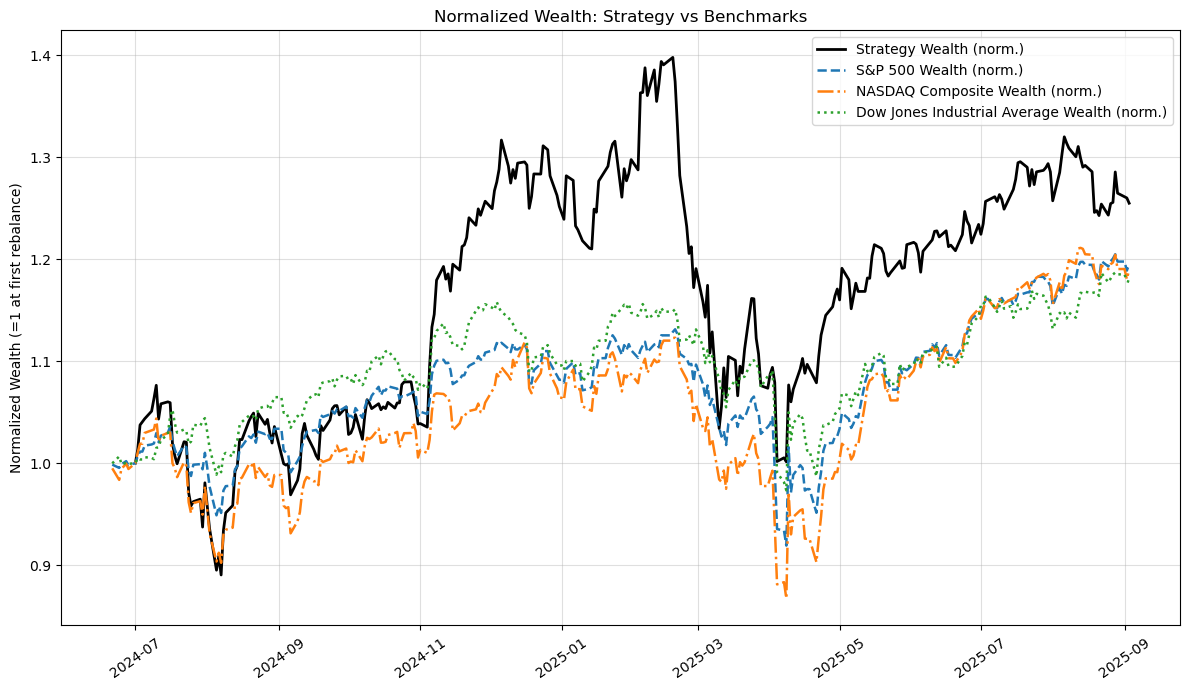

In [9]:
# GRAPH FOR NORMALIZED WEALTH ACCUMULATION FROM STOCK INDICES VS OUR PORTFOLIO STRATEGY
plt.figure(figsize=(12,7))
plt.plot(strategy_daily_dates, strategy_daily_norm, color="black", linewidth=2.0, label="Strategy Wealth (norm.)")
if indices_norm is not None:
    for indi in stock_indices:
        if indi in indices_norm.columns:
            plt.plot(indices_norm.index, indices_norm[indi].to_numpy(),
                     ls_map.get(indi,"--"), linewidth=1.8, label=f"{real_names_map[indi]} Wealth (norm.)")
plt.title("Normalized Wealth: Strategy vs Benchmarks")
plt.ylabel("Normalized Wealth (=1 at first rebalance)")
plt.xticks(rotation=35); plt.grid(True, alpha=0.4); plt.legend()
plt.tight_layout(); plt.savefig("out/wealth_vs_benchmarks.png", dpi=300)
print("Saved out/wealth_vs_benchmarks.png")

Saved out/simulation_graphs_with_benchmarks.png


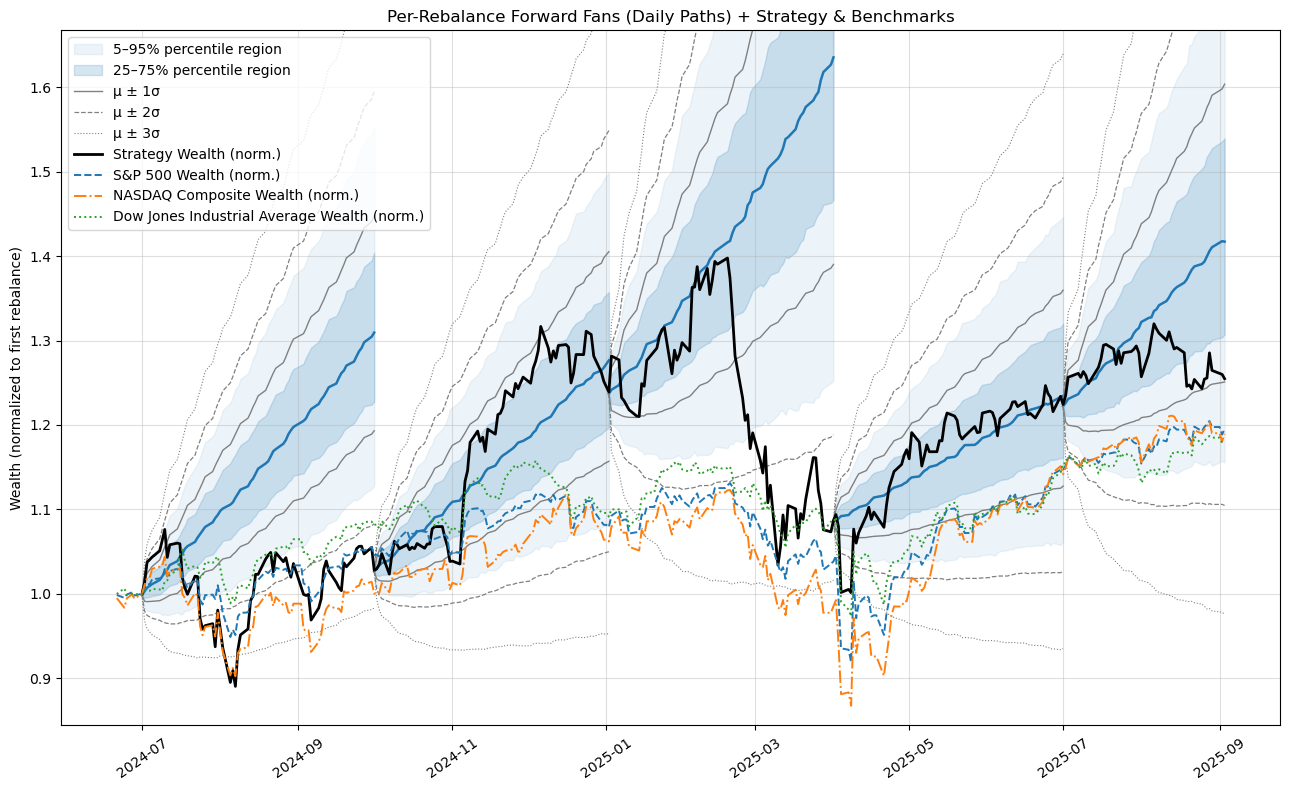

In [10]:
# GRAPH SHOWING NORMALIZED RETURNS FROM START COMPARED TO STOCHASTIC PORTFOLIO PERFORMANCE SIMULATIONS
plt.figure(figsize=(13,8))
rebalances = graph["rebalance_date"].drop_duplicates().tolist()

labeled_p95 = labeled_p75 = False
labeled_mu1 = labeled_mu2 = labeled_mu3 = False
index_labeled = False

for rebdate in rebalances:
    sub = graph[graph["rebalance_date"] == rebdate].copy()
    for c in ["pv_q05","pv_q25","pv_q50","pv_q75","pv_q95",
              "pv_mu_1s_lo","pv_mu_1s_hi","pv_mu_2s_lo","pv_mu_2s_hi","pv_mu_3s_lo","pv_mu_3s_hi"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    # percentile bands
    lab95 = "5–95% percentile region" if not labeled_p95 else None
    plt.fill_between(sub["date"], sub["pv_q05"], sub["pv_q95"], alpha=0.08, color="tab:blue", label=lab95)
    if not labeled_p95: labeled_p95 = True

    lab75 = "25–75% percentile region" if not labeled_p75 else None
    plt.fill_between(sub["date"], sub["pv_q25"], sub["pv_q75"], alpha=0.18, color="tab:blue", label=lab75)
    if not labeled_p75: labeled_p75 = True

    # median
    plt.plot(sub["date"], sub["pv_q50"], color="tab:blue", linewidth=1.8)

    # μ ± kσ lines
    lab1 = "μ ± 1σ" if not labeled_mu1 else None
    plt.plot(sub["date"], sub["pv_mu_1s_lo"], color="gray", linewidth=1.0, label=lab1)
    plt.plot(sub["date"], sub["pv_mu_1s_hi"], color="gray", linewidth=1.0)
    if not labeled_mu1: labeled_mu1 = True

    lab2 = "μ ± 2σ" if not labeled_mu2 else None
    plt.plot(sub["date"], sub["pv_mu_2s_lo"], color="gray", linewidth=0.9, linestyle="--", label=lab2)
    plt.plot(sub["date"], sub["pv_mu_2s_hi"], color="gray", linewidth=0.9, linestyle="--")
    if not labeled_mu2: labeled_mu2 = True

    lab3 = "μ ± 3σ" if not labeled_mu3 else None
    plt.plot(sub["date"], sub["pv_mu_3s_lo"], color="gray", linewidth=0.8, linestyle=":", label=lab3)
    plt.plot(sub["date"], sub["pv_mu_3s_hi"], color="gray", linewidth=0.8, linestyle=":")
    if not labeled_mu3: labeled_mu3 = True

# daily strategy + stock indices
plt.plot(strategy_daily_dates, strategy_daily_norm, color="black", linewidth=2.0, label="Strategy Wealth (norm.)")
if indices_norm is not None:
    for indi in stock_indices:
        if indi in indices_norm.columns:
            plt.plot(indices_norm.index, indices_norm[indi].to_numpy(),
                     ls_map.get(indi,"--"), linewidth=1.4,
                     label=(f"{real_names_map[indi]} Wealth (norm.)" if not index_labeled else None))
    index_labeled = True

plt.title("Per-Rebalance Forward Fans (Daily Paths) + Strategy & Benchmarks")
plt.ylabel("Wealth (normalized to first rebalance)")
plt.xticks(rotation=35); plt.grid(True, alpha=0.4); plt.legend()

extras = [strategy_daily_norm]
if indices_norm is not None:
    extras += [indices_norm[t].to_numpy() for t in indices_norm.columns]
clip_ylim_for_graphs(plt.gca(), graph, extra_series=extras)

plt.tight_layout(); plt.savefig("out/simulation_graphs_with_benchmarks.png", dpi=300)
print("Saved out/simulation_graphs_with_benchmarks.png")

Saved out/indices_rebased_by_rebalance.png


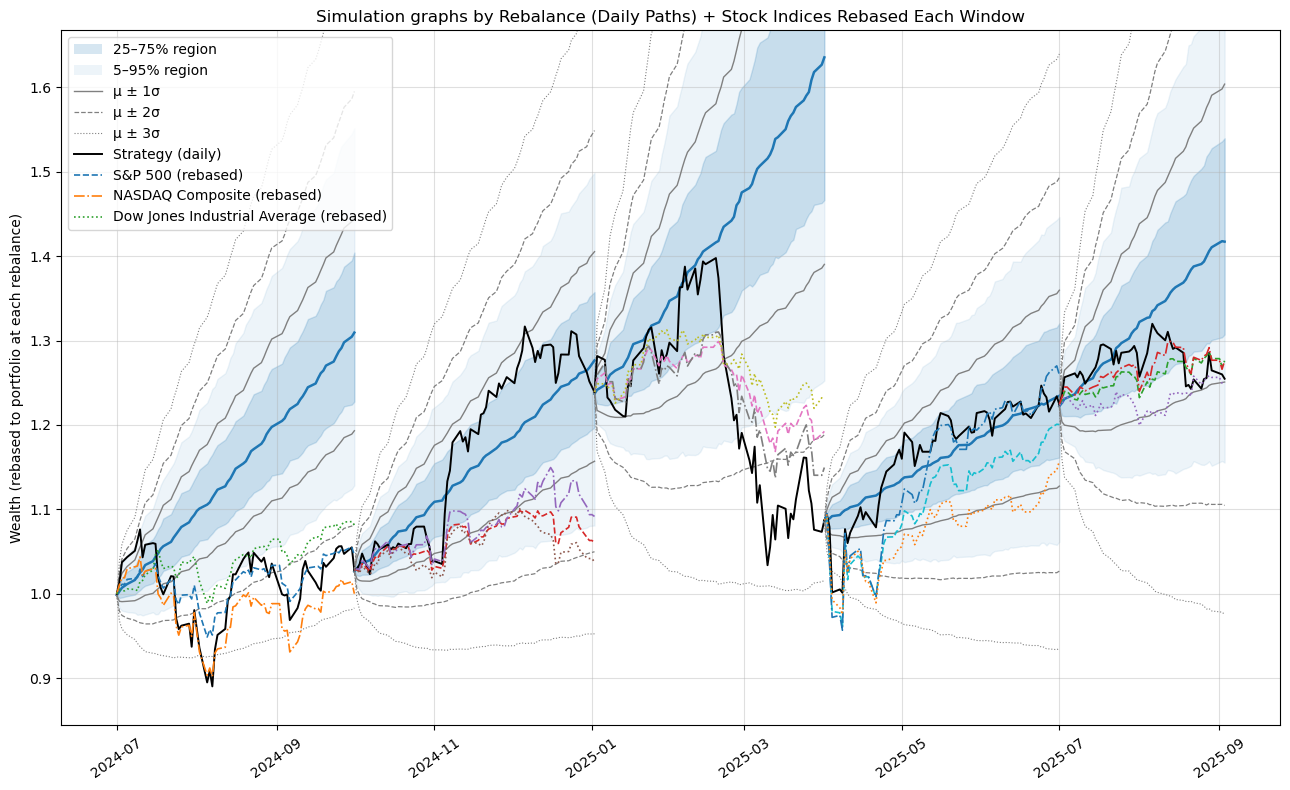

In [11]:
# GRAPH WITH ALL STOCK INDEX RETURNS NORMALIZED TO PORTFOLIO VALUE AT EACH REBALANCE, SO THAT WE CAN VISUALLY COMPARE
# ACTUAL STOCK MARKET PERFORMANCE COMPARED TO STOCHASTIC PREDICTIONS OF OUR STRATEGY AND ACTUAL PORTFOLIO
# PERFORMANCE AFTER EACH REBALANCE, WITHOUT BIAS INDUCED BY PERFORMANCE IN PREVIOUS REBALANCES. THIS HELPS US BETTER JUDGE
# HOW EACH SINGLE REBALANCE PERFORMED

plt.figure(figsize=(13,8))
for rebdate in rebalances:
    sub = graph[graph["rebalance_date"]==rebdate].copy()
    for c in ["pv_q05","pv_q25","pv_q50","pv_q75","pv_q95",
              "pv_mu_1s_lo","pv_mu_1s_hi","pv_mu_2s_lo","pv_mu_2s_hi","pv_mu_3s_lo","pv_mu_3s_hi"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    plt.fill_between(sub["date"], sub["pv_q05"], sub["pv_q95"], alpha=0.08, color="tab:blue")
    plt.fill_between(sub["date"], sub["pv_q25"], sub["pv_q75"], alpha=0.18, color="tab:blue")
    plt.plot(sub["date"], sub["pv_q50"], color="tab:blue", linewidth=1.8)
    plt.plot(sub["date"], sub["pv_mu_1s_lo"], color="gray", linewidth=1.0)
    plt.plot(sub["date"], sub["pv_mu_1s_hi"], color="gray", linewidth=1.0)
    plt.plot(sub["date"], sub["pv_mu_2s_lo"], color="gray", linewidth=0.9, linestyle="--")
    plt.plot(sub["date"], sub["pv_mu_2s_hi"], color="gray", linewidth=0.9, linestyle="--")
    plt.plot(sub["date"], sub["pv_mu_3s_lo"], color="gray", linewidth=0.8, linestyle=":")
    plt.plot(sub["date"], sub["pv_mu_3s_hi"], color="gray", linewidth=0.8, linestyle=":")

    # strategy daily segment for this window
    m = (strategy_daily_dates >= rebdate) & (strategy_daily_dates <= sub["date"].iloc[-1])
    plt.plot(strategy_daily_dates[m], strategy_daily_norm[m], color="black", linewidth=1.4)

    # indices normalized to strategy at the rebalance
    if indices_norm is not None:
        s_rebalance = strategy_daily_norm[strategy_daily_dates.searchsorted(rebdate)]
        indices_at_rebalance = indices_norm.reindex([rebdate], method="pad").iloc[0]
        rng = indices_norm.loc[:sub["date"].iloc[-1]].loc[rebdate:]
        for indi in stock_indices:
            if indi in rng.columns:
                rebased = rng[indi] / indices_at_rebalance[indi] * s_rebalance
                plt.plot(rebased.index, rebased.to_numpy(), ls_map.get(indi,"--"), linewidth=1.2)

# compact legend (one entry per type)
legend_items = [
    Patch(facecolor="tab:blue", alpha=0.18, label="25–75% region"),
    Patch(facecolor="tab:blue", alpha=0.08, label="5–95% region"),
    Line2D([0],[0], color="gray", lw=1.0, label="μ ± 1σ"),
    Line2D([0],[0], color="gray", lw=0.9, ls="--", label="μ ± 2σ"),
    Line2D([0],[0], color="gray", lw=0.8, ls=":", label="μ ± 3σ"),
    Line2D([0],[0], color="black", lw=1.4, label="Strategy (daily)"),
    Line2D([0],[0], color="C0", lw=1.2, ls="--", label="S&P 500 (rebased)"),
    Line2D([0],[0], color="C1", lw=1.2, ls="-.", label="NASDAQ Composite (rebased)"),
    Line2D([0],[0], color="C2", lw=1.2, ls=":",  label="Dow Jones Industrial Average (rebased)"),
]
plt.legend(handles=legend_items, loc="upper left")

plt.title("Simulation graphs by Rebalance (Daily Paths) + Stock Indices Rebased Each Window")
plt.ylabel("Wealth (rebased to portfolio at each rebalance)")
plt.xticks(rotation=35); plt.grid(True, alpha=0.4)
extras = [strategy_daily_norm]
if indices_norm is not None:
    extras += [indices_norm[t].to_numpy() for t in indices_norm.columns]

clip_ylim_for_graphs(plt.gca(), graph, extra_series=extras)

plt.tight_layout(); plt.savefig("out/indices_rebased_by_rebalance.png", dpi=220)
print("Saved out/indices_rebased_by_rebalance.png")

In [12]:
# SOME METRICS
summary["realized_ret"] = summary["portfolio_value"].pct_change()
h = summary["realized_ret"].astype(float).to_numpy()
with np.errstate(all="ignore"):
    n_all = np.sum(~np.isnan(h)); ddof_all = 1 if n_all >= 2 else 0
    mean_ret = np.nanmean(h); std_ret = np.nanstd(h, ddof=ddof_all)
    neg = h[h < 0]; n_neg = np.sum(~np.isnan(neg)); ddof_neg = 1 if n_neg >= 2 else 0
    downside = np.nanstd(neg, ddof=ddof_neg) if n_neg > 0 else np.nan
sharpe  = (mean_ret / std_ret) if (std_ret and std_ret > 0) else np.nan
sortino = (mean_ret / downside) if (downside and downside > 0) else np.nan
pv = summary["portfolio_value"].astype(float)
maxdd = (pv / pv.cummax() - 1).min()
print(f"Sharpe(horizon): {sharpe:.3f} | Sortino(horizon): {sortino:.3f} | MaxDD: {maxdd:.2%}")

Sharpe(horizon): 0.419 | Sortino(horizon): nan | MaxDD: -12.26%
